In [1]:
import os
import random
from tqdm import tqdm
import glob
from PIL import Image, ImageDraw

In [9]:
anno_path = "/workspace/traffic_light/submission/wbf_v5_yolo_dino_co/3_epoch_co_detr_nms(0.001)_cut"
image_path = "/workspace/traffic_light/data/detection/test/images"

In [10]:
categories = [
    "veh_go",
    "veh_goLeft",
    "veh_noSign",
    "veh_stop",
    "veh_stopLeft",
    "veh_stopWarning",
    "veh_warning",
    "ped_go",
    "ped_noSign",
    "ped_stop",
    "bus_go",
    "bus_noSign",
    "bus_stop",
    "bus_warning",
]
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

In [11]:
import numpy as np
def nms(bounding_boxes, confidence_score, labels, threshold):
    """
    ref: https://github.com/amusi/Non-Maximum-Suppression/blob/master/nms.py
    the boxes format is xyxy
    e.g) 
    bounding_boxes = [(187, 82, 337, 317), (150, 67, 305, 282), (246, 121, 368, 304)]
    confidence_score = [0.9, 0.75, 0.8]
    threshold = 0.4
    """
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []
    picked_labels = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])
        picked_labels.append(labels[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score, picked_labels

# Random visualization

10000000.jpg

boxes:  11


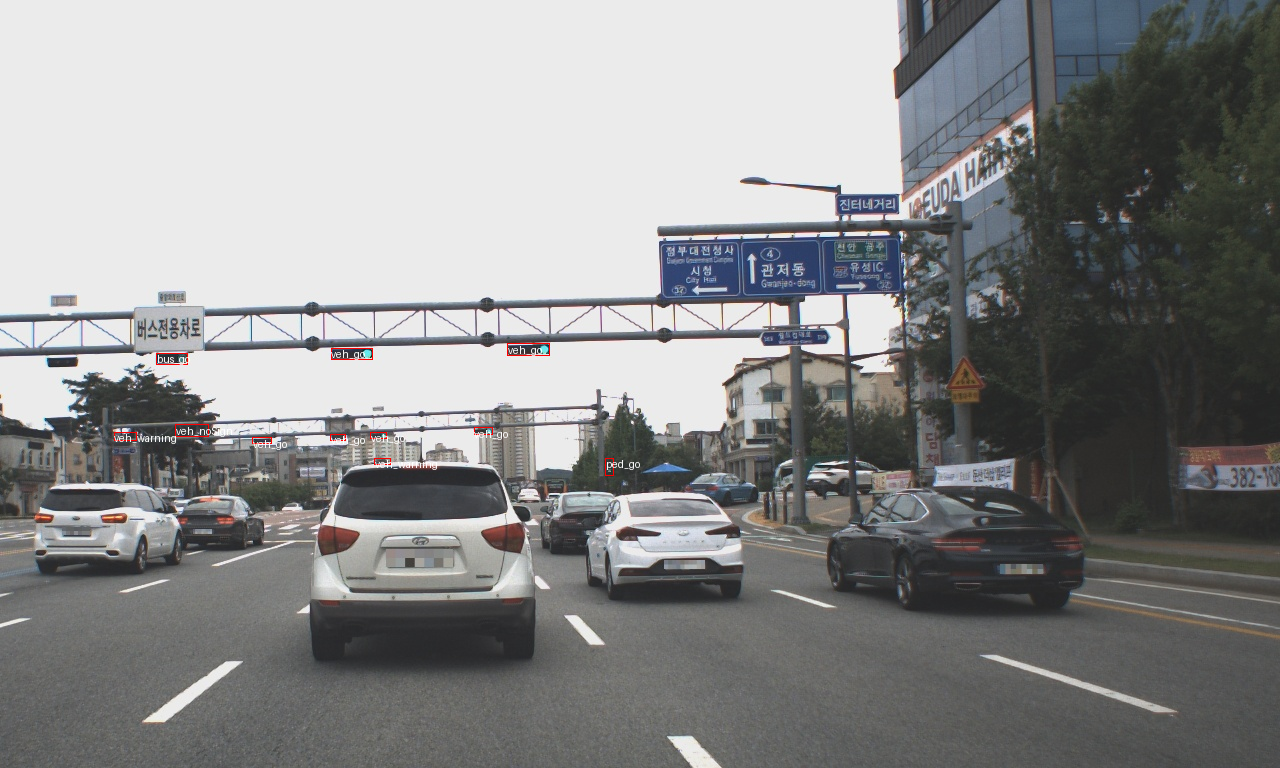

In [16]:
nms_iou_threshold = 0
cs_threshold=0.0

annos = os.listdir(anno_path)
# random_num = random.randrange(10000000, 10000000 + len(annos))
# random_num = random.randrange(10005000, 00006600)# + len(annos))
random_num = '10000000'

test_anno = os.path.join(anno_path, f"{random_num}.txt")
sample_img = os.path.join(image_path, f"{random_num}.jpg")
print(os.path.basename(sample_img))
img = Image.open(sample_img)
original_w, original_h = img.size
draw = ImageDraw.Draw(img)

cnt = 0
with open(test_anno, "r") as file:
    bboxes=[]
    scores=[]
    class_ids=[]
    for line in file:
        class_id, norm_center_x, norm_center_y, norm_w, norm_h, cs= line.split()
        if float(cs) < cs_threshold:
            continue
        
        class_id = int(class_id)
        norm_center_x = float(norm_center_x)
        norm_center_y = float(norm_center_y)
        norm_w = float(norm_w)
        norm_h = float(norm_h)
        # print(cs, end=' ')
        
        # if (norm_center_y-(norm_h/2)) > 0.7: # remove too big boxes
        #     continue
        
        cnt +=1 
        # print( norm_center_x, norm_center_y, norm_w, norm_h)
        x_min = (norm_center_x - norm_w / 2) * original_w
        y_min = (norm_center_y - norm_h / 2) * original_h
        x_max = (norm_center_x + norm_w / 2) * original_w #+ norm_w * original_w
        y_max = (norm_center_y + norm_h / 2) * original_h #+ norm_h * original_h

        bboxes.append([x_min, y_min, x_max, y_max])
        scores.append(cs)
        class_ids.append(class_id)

    if nms_iou_threshold:
        bboxes, picked_score, class_ids = nms(bboxes, scores, class_ids, nms_iou_threshold)
    for boxes, class_id in zip(bboxes, class_ids):
        x1, y1, x2, y2 = boxes
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), id2label[class_id], fill="white")

print()
print('boxes: ', cnt)
img

# Save visualization images

In [ ]:
anno_path = "/workspace/traffic_light/submission/wbf_v5_yolo_dino_co/3_epoch_co_detr_nms(0.001)_cut"
image_path = "/workspace/traffic_light/data/detection/test/images"
output_label_path="/workspace/traffic_light/1_epoch/"

os.makedirs(output_label_path, exist_ok=True)
nms_iou_threshold = 0
cs_threshold=0.0

annos = os.listdir(anno_path)
img_list=sorted(glob.glob(f'{image_path}/*.jpg'))

for img_path in tqdm(img_list):
    img = Image.open(img_path)
    file_name=os.path.splitext(os.path.basename(img_path))[0]
    original_w, original_h = img.size
    draw = ImageDraw.Draw(img)
    test_anno=os.path.join(anno_path, f'{file_name}.txt')
    cnt = 0
    with open(test_anno, "r") as file:
        bboxes=[]
        scores=[]
        class_ids=[]
        for line in file:
            class_id, norm_center_x, norm_center_y, norm_w, norm_h, cs= line.split()
            if float(cs) < cs_threshold:
                continue
            
            class_id = int(class_id)
            norm_center_x = float(norm_center_x)
            norm_center_y = float(norm_center_y)
            norm_w = float(norm_w)
            norm_h = float(norm_h)
            # print(cs, end=' ')
            if (norm_center_y-(norm_h/2)) > 0.7:
                continue
            cnt +=1 
            # print( norm_center_x, norm_center_y, norm_w, norm_h)
            x_min = (norm_center_x - norm_w / 2) * original_w
            y_min = (norm_center_y - norm_h / 2) * original_h
            x_max = (norm_center_x + norm_w / 2) * original_w #+ norm_w * original_w
            y_max = (norm_center_y + norm_h / 2) * original_h #+ norm_h * original_h

            bboxes.append([x_min, y_min, x_max, y_max])
            scores.append(cs)
            class_ids.append(class_id)

        if nms_iou_threshold:
            bboxes, picked_score, class_ids = nms(bboxes, scores, class_ids, nms_iou_threshold)
        for boxes, class_id in zip(bboxes, class_ids):
            x1, y1, x2, y2 = boxes
            draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
            draw.text((x1, y1), id2label[class_id], fill="white")

            img.save(os.path.join(output_label_path, f'{file_name}.jpg'), 'JPEG')
print()
print(cnt)